In [ ]:
#%pip install matplotlib ray
#!pip freeze | grep jax
#%pip install jax==0.3.22 jaxlib==0.3.22+cuda11.cudnn805 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Install and import 

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import os

In [3]:
from tqdm import tqdm


def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])


def show_ray_progress(res):
    for x in tqdm(to_iterator(res), total=len(res)):
        pass
    return ray.get(res)

In [4]:
workdir = "/work/fukai/basicpy"
os.makedirs(workdir, exist_ok=True)

In [5]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)
import jax

jax.config.update("jax_platform_name", "gpu")

gpu


In [6]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
import time
from skimage import filters

plt.rcParams["font.family"] = ""

# Generate test data 

## Make parabola

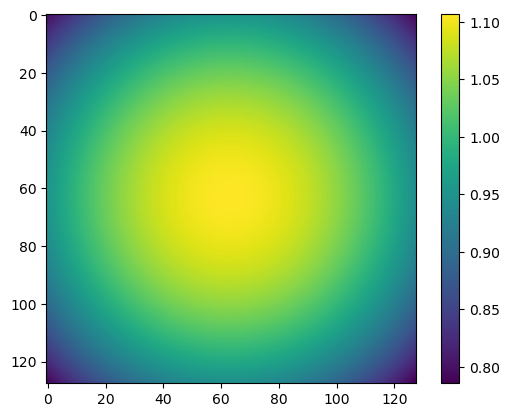

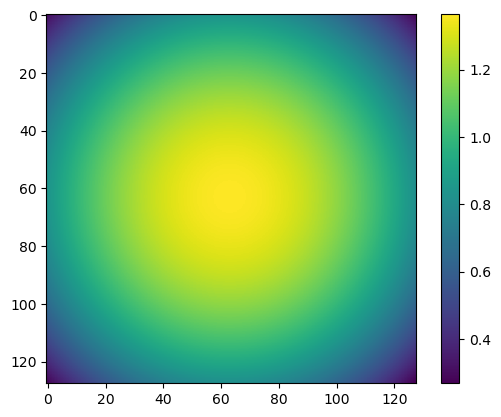

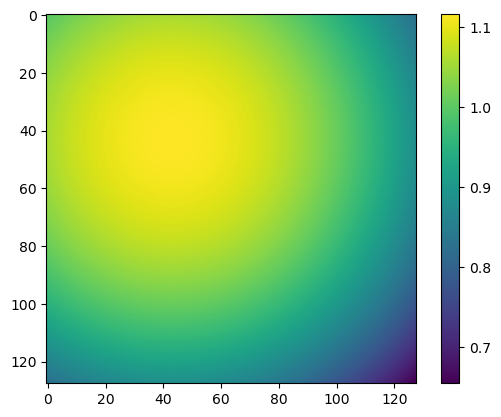

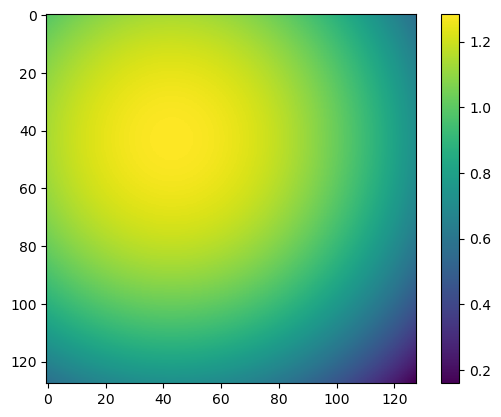

In [7]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

In [8]:
np.save("flatfield_profiles.npy", flatfield_profiles)

## Make images with blobs 

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

In [129]:
blob_size = 6
blob_dist = lambda: np.random.normal(0, 100)

In [130]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        poss = np.array(
            [
                [
                    np.random.uniform(
                        -size // 2 + 1,
                        size // 2,
                    )
                    for size in true_flatfield.shape
                ]
                for _ in range(np.random.poisson(ave_count))
            ]
        )
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = filters.gaussian(np.random.poisson(image), sigma=1, preserve_range=True)
        images.append(image)
    return np.array(images)

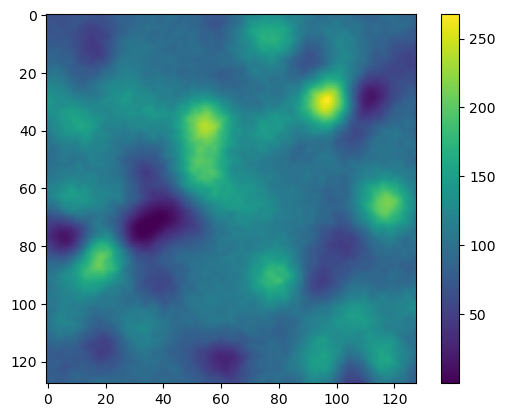

In [131]:
images = generate_cluttered_images(flatfield_profiles[0], 100, 10, 100, blob_dist)
plt.imshow(images[0])
plt.colorbar()

In [132]:
jax.config.update("jax_platform_name", "cpu")

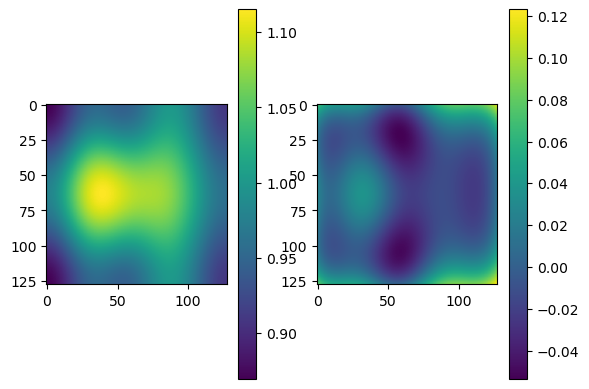

In [133]:
b = BaSiC(get_darkfield=False, smoothness_flatfield=7)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

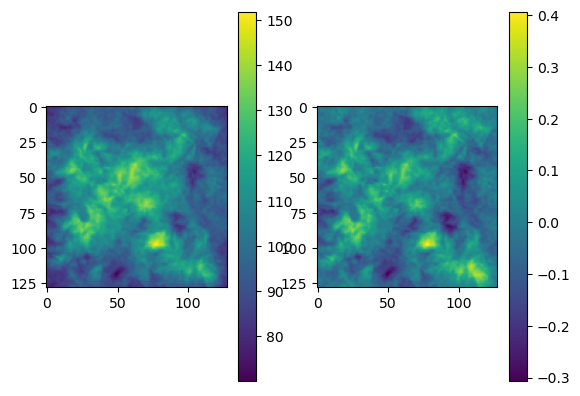

In [134]:
median_image = np.median(images, axis=0)
plt.subplot(121)
plt.imshow(median_image)
plt.colorbar()
plt.subplot(122)
plt.imshow(median_image / np.mean(median_image) - flatfield_profiles[0])
plt.colorbar()

In [135]:
blob_dists

{'unbiased': <function __main__.<lambda>()>,
 'biased': <function __main__.<lambda>()>}

In [148]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 100),
    "biased": lambda: np.random.normal(50, 100),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [30, 100],  # ave_count
        [10, 100, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        range(5),
    )
)

parameters = []
imagess = []
for (true_flatfield_id, intensity, ave_count, n_images, blob_dist_key, rep) in tqdm(
    conditions
):
    p = {
        "true_flatfield_id": true_flatfield_id,
        "intensity": intensity,
        "ave_count": ave_count,
        "n_images": n_images,
        "blob_dist_key": blob_dist_key,
        "rep": rep,
    }
    parameters.append(p)
    imagess.append(
        generate_cluttered_images(
            flatfield_profiles[true_flatfield_id],
            intensity=intensity,
            n_images=n_images,
            ave_count=ave_count,
            blob_dist=blob_dists[blob_dist_key],
        )
    )
#    plt.imshow(imagess[-1][0])
#    plt.show()
#    break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [47:37<00:00,  3.97s/it]


In [149]:
# show_ray_progress(imagess)

In [150]:
# imagess = ray.get(imagess)

In [151]:
with open(path.join(workdir, "wo_darkfield_imagess.pickle"), "wb") as f:
    pickle.dump(imagess, f)

In [152]:
pd.DataFrame.from_records(parameters).to_csv(
    path.join(workdir, "wo_darkfield_parameters.csv")
)

In [153]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [154]:
with open(path.join(workdir, "wo_darkfield_imagess.pickle"), "rb") as f:
    imagess = pickle.load(f)

In [155]:
!mkdir -p wo_darkfield_imagess

In [156]:
for j, images in enumerate(imagess):
    np.save(f"wo_darkfield_imagess/{j}.npy", images)

In [157]:
del imagess

# Baseline value

In [9]:
parameters_df = pd.read_csv(
    path.join(workdir, "wo_darkfield_parameters.csv"), index_col=0
)
# parameters_df = parameters_df.iloc[:900]

In [10]:
ii = 210
parameters_df.iloc[ii]

true_flatfield_id         1
intensity                10
ave_count               100
n_images                 10
blob_dist_key        biased
rep                       0
Name: 210, dtype: object

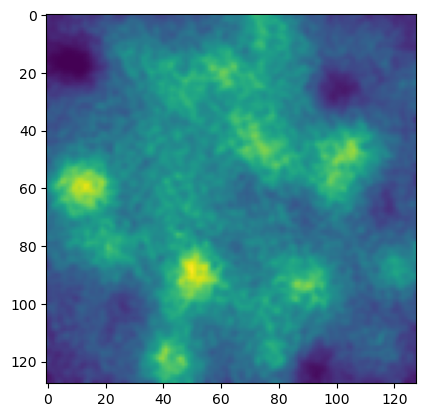

In [11]:
images = np.load(f"wo_darkfield_imagess/{ii}.npy")
plt.imshow(images[0])

In [176]:
baseline_results = []
for j, p in tqdm(
    enumerate(parameters_df.to_dict(orient="records")), total=len(parameters_df)
):
    images = np.load(f"wo_darkfield_imagess/{j}.npy")
    sigmas = np.arange(20)
    deviation = []
    for sigma in sigmas:
        median_image = np.median(images, axis=0)
        #        plt.subplot(121)
        #        plt.imshow(median_image)
        if sigma > 0:
            median_image = filters.gaussian(median_image, sigma=sigma)
        median_image = median_image / median_image.mean()
        d = np.mean(np.abs(flatfield_profiles[p["true_flatfield_id"]] - median_image))
        deviation.append(d)
    #        plt.subplot(122)
    #        plt.imshow(median_image)
    p2 = p.copy()
    p2["deviation"] = np.min(deviation)
    baseline_results.append(p2)
baseline_results_df = pd.DataFrame.from_records(baseline_results)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [1:17:46<00:00,  6.48s/it]


In [177]:
baseline_results_df = pd.DataFrame.from_records(baseline_results)
baseline_results_df.to_csv("baseline_results.csv")

# Fit images

In [12]:
jax.config.update("jax_platform_name", "gpu")

In [13]:
# parameters_df = pd.DataFrame.from_records(parameters)
# ind = (parameters_df["n_images"]<900).values
# parameters_df2 = parameters_df[ind].copy()
# imagess2 = [imagess[ii] for ii in np.nonzero(ind)[0]]
"""
assert len(parameters_df2) == len(imagess2)
with open("wo_darkfield_imagess2.pickle","wb") as f:
    pickle.dump(imagess2,f)
parameters_df2.to_csv("wo_darkfield_parameters2.csv")
"""

'\nassert len(parameters_df2) == len(imagess2)\nwith open("wo_darkfield_imagess2.pickle","wb") as f:\n    pickle.dump(imagess2,f)\nparameters_df2.to_csv("wo_darkfield_parameters2.csv")\n'

In [14]:
parameters_df["image_index"] = np.arange(len(parameters_df))

In [15]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)

In [16]:
flatfields = []
baselines = []
b = BaSiC(
    get_darkfield=False,
)
estimated_parameters = []
b_cpu = BaSiC(
    get_darkfield=False,
)

In [17]:
current_num = len(estimated_parameters)
flatfields = flatfields[:current_num]
assert len(flatfields) == current_num

In [18]:
current_num, len(flatfields)

(0, 0)

In [19]:
jax.config.update("jax_platform_name", "gpu")
print(jax.devices())
jax.config.update("jax_platform_name", "cpu")

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0), StreamExecutorGpuDevice(id=2, process_index=0), StreamExecutorGpuDevice(id=3, process_index=0)]


In [ ]:
# q = "true_flatfield_id==0 and ave_count==100 and blob_dist_key=='unbiased'"
# _df = parameters_df  # .query(q)
ii = 0

for j, p in tqdm(
    enumerate(parameters_df.to_dict(orient="records")), total=len(parameters_df)
):
    images = np.load(f"wo_darkfield_imagess/{j}.npy")
    #!echo {p["image_index"]} > log.txt
    for fitting_mode, smoothness_flatfield in product(
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-1, 1.5, 7)),  # smoothness_flatfield
    ):
        ii = ii + 1
        if ii <= current_num:
            continue
        p2 = p.copy()
        p2.update(
            {
                "fitting_mode": fitting_mode,
                "smoothness_flatfield": smoothness_flatfield,
            }
        )
        #        query = " and ".join([f"{k}==@p2['{k}']" for k,v in list(p2.items()) if k!= "smoothness_flatfield"])
        #        _df_sel = estimated_parameters_df.query(query)
        #        _row = _df_sel[np.isclose(_df_sel["smoothness_flatfield"],p2["smoothness_flatfield"])]
        #        assert len(_row) == 1

        jax.config.update("jax_platform_name", "gpu")
        jax.config.update("jax_default_device", jax.devices()[0])
        b.fitting_mode = fitting_mode
        b.smoothness_flatfield = smoothness_flatfield
        start = time.time()
        b.fit(images)
        stop = time.time()
        p2["time_gpu"] = stop - start
        flatfields.append(b.flatfield)
        baselines.append(b.baseline)

        jax.config.update("jax_platform_name", "cpu")

        if (
            p["true_flatfield_id"] == 0
            and p["ave_count"] == 100
            and p["blob_dist_key"] == "unbiased"
        ):
            b_cpu.fitting_mode = fitting_mode
            b_cpu.smoothness_flatfield = smoothness_flatfield
            start = time.time()
            b_cpu.fit(images)
            stop = time.time()
            p2["time_cpu"] = stop - start
            assert np.allclose(b_cpu.flatfield, b.flatfield)
            assert np.allclose(b_cpu.baseline, b.baseline)
        else:
            b_cpu.fit(datasets.wsi_brain())

        estimated_parameters.append(p2)

        current_num = len(estimated_parameters)
        assert len(flatfields) == current_num

  0%|▋                                                                                                                                                                                                                                                            | 2/720 [01:02<5:38:43, 28.31s/it]WARNING:basicpy.basicpy:Single-step optimization did not converge at the last reweighting step.


In [ ]:
estimated_parameters_df = pd.DataFrame.from_records(estimated_parameters).reset_index(
    drop=True
)
estimated_parameters_df

In [ ]:
len(estimated_parameters)

In [ ]:
np.save("flatfields.npy", flatfields)

In [ ]:
len(flatfields)

In [ ]:
estimated_parameters_df

# Calculate deviation

In [ ]:
flatfields = np.load("flatfields.npy")

In [ ]:
assert len(estimated_parameters_df) == len(flatfields)

In [ ]:
for (i, row), flatfield in zip(estimated_parameters_df.iterrows(), flatfields):
    estimated_parameters_df.loc[i, "deviation"] = np.mean(
        np.abs(flatfield - flatfield_profiles[row["true_flatfield_id"]])
    )

In [ ]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df.csv")
estimated_parameters_df.head()

# Calculate autotune metric

In [ ]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df.csv", index_col=0
)
estimated_parameters_df.head()

In [ ]:
plt.plot(estimated_parameters_df["time_gpu"], estimated_parameters_df["time_cpu"], ".")
plt.xlabel("gpu time (s)")
plt.ylabel("cpu time (s)")
plt.plot([0, 2], [0, 2])

In [ ]:
assert len(flatfields) == len(estimated_parameters_df)

## Calculate histogram ranges 

In [ ]:
import ray

ray.shutdown()
ray.init(num_cpus=20)

In [ ]:
histogram_qmin: float = 0.01
histogram_qmax: float = 0.99
vmin_factor: float = 0.6
vrange_factor: float = 1.5
histogram_bins: int = 1000
histogram_use_fitting_weight: bool = True
fourier_l0_norm_image_threshold: float = 0.1
fourier_l0_norm_fourier_radius = 10
fourier_l0_norm_threshold = 0
fourier_l0_norm_cost_coef = 30

In [ ]:
def calc_vrange(fitting_mode, image_index):
    import warnings

    warnings.simplefilter("ignore", DeprecationWarning)
    b = BaSiC(
        get_darkfield=False,
    )
    images = np.load(f"wo_darkfield_imagess/{int(image_index)}.npy")
    b.fitting_mode = fitting_mode
    b.smoothness_flatfield = 0.1
    b.fit(images)
    transformed = b.transform(images, timelapse=False)
    vmin, vmax = np.quantile(transformed, [histogram_qmin, histogram_qmax])
    val_range = (
        vmax - vmin * vmin_factor
    ) * vrange_factor  # fix the value range for histogram
    return (fitting_mode, image_index), val_range


ress = []
for (fitting_mode, image_index), _ in tqdm(
    list(estimated_parameters_df.groupby(["fitting_mode", "image_index"]))[:]
):
    ress.append(ray.remote(calc_vrange).remote(fitting_mode, image_index))

In [ ]:
show_ray_progress(ress);

In [ ]:
vranges = dict(ray.get(ress))

In [ ]:
with open("vranges.pickle", "wb") as f:
    pickle.dump(vranges, f)

## Calc metrics

In [ ]:
with open("vranges.pickle", "rb") as f:
    vranges = pickle.load(f)

In [ ]:
ress = []


def calc_autotune_cost(i, row, flatfield):
    images = np.load(f"wo_darkfield_imagess/{int(row['image_index'])}.npy")
    val_range = vranges[(row["fitting_mode"], int(row["image_index"]))]
    b = BaSiC(
        get_darkfield=False,
    )

    b.fitting_mode = row["fitting_mode"]
    b.smoothness_flatfield = row["smoothness_flatfield"]
    b.flatfield = flatfield
    b.darkfield = np.zeros_like(flatfield)
    b.baseline = np.ones(images.shape[0])
    transformed = b.transform(images, timelapse=False)
    entropy_vmin = np.quantile(transformed, histogram_qmin) * vmin_factor
    entropy_vmax = entropy_vmin + val_range
    e = metrics.entropy(
        transformed,
        vmin=entropy_vmin,
        vmax=entropy_vmax,
        bins=histogram_bins,
        clip=True,
    )
    n = metrics.fourier_L0_norm(
        b.flatfield,
        fourier_l0_norm_image_threshold,
        fourier_l0_norm_fourier_radius,
    )
    cost = metrics.autotune_cost(
        transformed,
        flatfield,
        entropy_vmin=entropy_vmin,
        entropy_vmax=entropy_vmax,
        histogram_bins=histogram_bins,
        fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
        fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
        fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
        fourier_l0_norm_threshold=fourier_l0_norm_threshold,
    )
    return i, e, n, cost


for (i, row), flatfield in tqdm(
    list(zip(estimated_parameters_df.iterrows(), flatfields))
):
    ress.append(ray.remote(calc_autotune_cost).remote(i, row, flatfield))

In [ ]:
show_ray_progress(ress);

In [ ]:
for i, e, n, cost in ray.get(ress):
    estimated_parameters_df.loc[i, "entropy"] = e
    estimated_parameters_df.loc[i, "fourier_L0_norm"] = n
    estimated_parameters_df.loc[i, "autotune_cost"] = cost

In [ ]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df_with_autotune.csv")

In [ ]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df_with_autotune.csv"
)

In [ ]:
estimated_parameters_df.query("intensity==1000").head()

In [ ]:
assert all(estimated_parameters_df.index == np.arange(len(estimated_parameters_df)))

In [ ]:
for (i, row) in tqdm(
    list(
        estimated_parameters_df.query(
            "intensity==1000 and n_images==1000 and ave_count==0"
        ).iterrows()
    )[:6]
):
    flatfield = flatfields[i]
    images = np.load(f"wo_darkfield_imagess/{int(row['image_index'])}.npy")
    val_range = vranges[(row["fitting_mode"], int(row["image_index"]))]
    b = BaSiC(
        get_darkfield=False,
    )

    b.fitting_mode = row["fitting_mode"]
    b.smoothness_flatfield = row["smoothness_flatfield"]
    b.flatfield = flatfield
    b.darkfield = np.zeros_like(flatfield)
    b.baseline = np.ones(images.shape[0])
    transformed = images / flatfield[np.newaxis]  # b.transform(images, timelapse=False)
    entropy_vmin = np.quantile(transformed, histogram_qmin) * vmin_factor
    entropy_vmax = entropy_vmin + val_range
    e = metrics.entropy(
        transformed,
        vmin=entropy_vmin,
        vmax=entropy_vmax,
        bins=histogram_bins,
        clip=True,
    )
    plt.figure(figsize=(12, 3))
    plt.subplot(141)
    # plt.hist(transformed.flatten(),bins=histogram_bins,range=(entropy_vmin,entropy_vmax))
    plt.hist(transformed.flatten(), bins=histogram_bins)  # ,range=(900,1100))
    plt.subplot(142)
    plt.imshow(images[0])
    plt.subplot(143)
    plt.imshow(transformed[0])
    plt.subplot(144)
    plt.imshow(flatfield)
    plt.colorbar()
    plt.title(f"entropy={e:.4f}")
    plt.show()

In [ ]:
keys = [
    "true_flatfield_id",
    "intensity",
    "ave_count",
    "n_images",
    "blob_dist_key",
    "fitting_mode",
]
for vals, grp in estimated_parameters_df.groupby(keys):
    if vals[3] < 100:
        continue
    for rep, grp2 in grp.groupby("rep"):
        plt.plot(grp2["smoothness_flatfield"], grp2["deviation"], "o-")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deviation (L1 norm)")
    plt.ylabel("entropy")
    break
    # plt.ylim(1.2,1.6)
plt.show()

In [ ]:
keys = [
    "true_flatfield_id",
    "intensity",
    "ave_count",
    "n_images",
    "blob_dist_key",
    "fitting_mode",
]
for vals, grp in estimated_parameters_df.groupby(keys):
    if vals[3] < 100:
        continue
    for rep, grp2 in grp.groupby("rep"):
        plt.plot(grp2["deviation"], grp2["entropy"], "o-")
    # plt.yscale("log")
    plt.xlabel("deviation (L1 norm)")
    plt.ylabel("entropy")
    # plt.ylim(1.2,1.6)
    plt.show()
    break